0.1.1 1. Classification with KNN:

In [99]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, preprocessing
warnings.filterwarnings(action='ignore') # Turn off the␣warnings.
%matplotlib inline

1.1. Read in data:

The data and explanation can be found here (requires sign in).

!wget --no-clobber https://raw.githubusercontent.com/stefannae/
↪SIC-Artificial-Intelligence/main/SIC_AI_Coding_Exercises/
↪SIC_AI_Chapter_06_Coding_Exercises/data_titanic.csv


In [100]:
df = pd.read_csv('data_titanic.csv', header='infer')


In [101]:
df.shape

(891, 12)

In [102]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


1.2. Missing value processing:

In [103]:
# Check for the missing values.
df.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [104]:
n = df.shape[0]
# Danh sách tạm để chứa các giá trị tuổi
Age = []
for i in range(n):
    if np.isnan(df.Age[i]):
        if ('Mr' in df.Name[i]) or ('Mrs' in df.Name[i]):
            Age.append(30)  # Nếu trong tên có 'Mr' hoặc 'Mrs', điền giá trị 30
        else:
            Age.append(10)  # Nếu không, điền giá trị 10 (có khả năng là trẻ em)
    else:
        Age.append(df.Age[i])

# Cập nhật cột Age trong DataFrame
df.Age = pd.Series(Age)

In [105]:
# We will drop some columns.
df = df.drop(columns = ['PassengerId','Name','Ticket','Fare','Cabin'])
df.head(3)


,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S


In [106]:
# Delete the rest of missing values.
df=df.dropna(axis=0)
df.shape

(889, 7)

1.3. Exploratory data analysis:

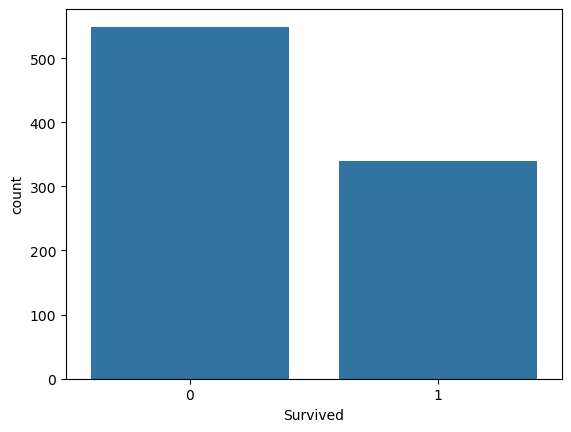

In [107]:
# The frequency table of Survived.
sns.countplot(data=df, x="Survived")
plt.show()

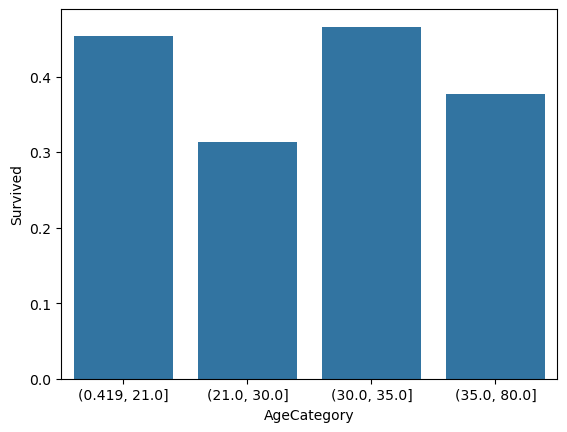

In [108]:
# Survival rate by Age category.
df['AgeCategory'] = pd.qcut(df.Age,4) 
# Using quantiles cut␣into 4 intervals.
sns.barplot(x='AgeCategory',y='Survived', ci=None, data=df)
plt.show()


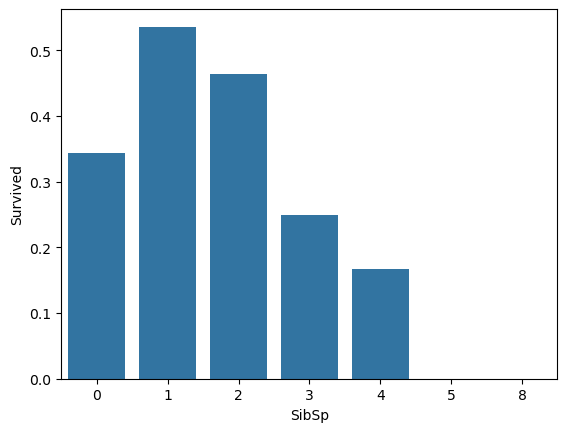

In [109]:
# Survival rate by SibSp category.
sns.barplot(x='SibSp', y='Survived', ci=None, data=df)
plt.show()


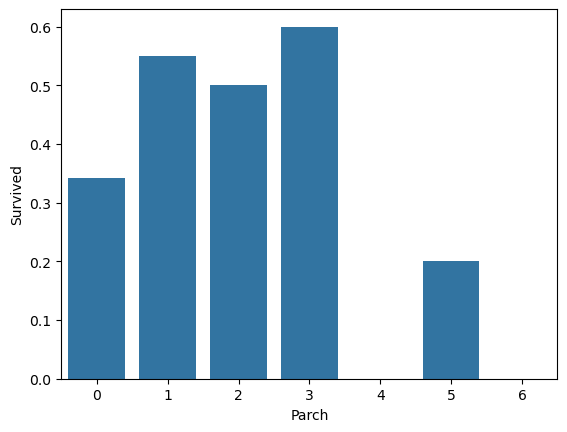

In [110]:
# Survival rate by Parch.
sns.barplot(x='Parch', y='Survived', ci=None, data=df)
plt.show()


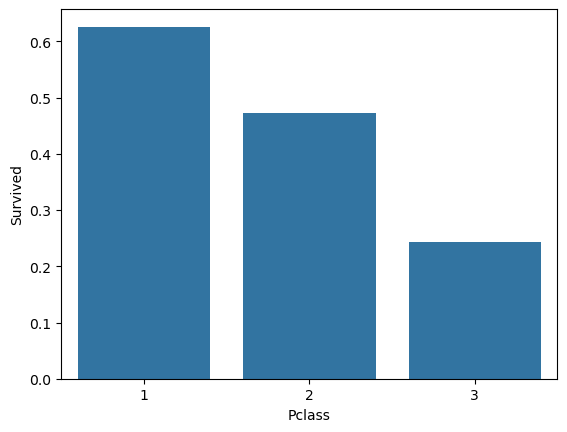

In [111]:
# Survival rate by Pclass.
sns.barplot(x='Pclass', y='Survived', ci=None, data=df)
plt.show()

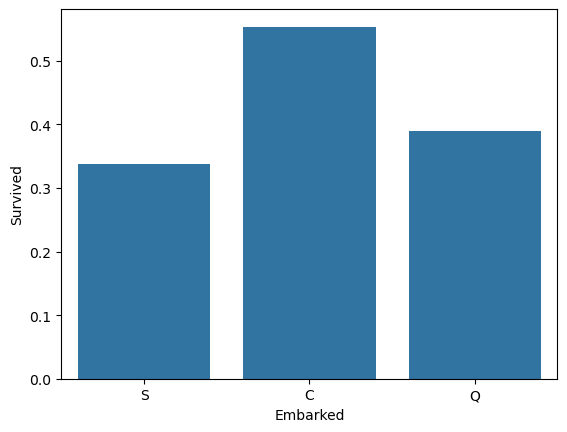

In [112]:
# Survival rate by Embarked.
sns.barplot(x='Embarked', y='Survived', ci=None, data=df)
plt.show()


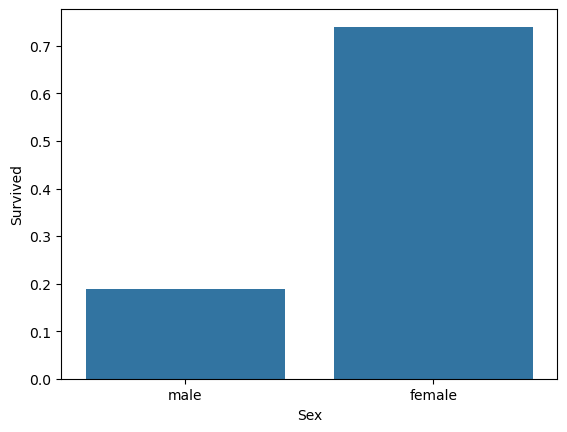

In [113]:
# Survival rate by Sex.
sns.barplot(x='Sex', y='Survived', ci=None, data=df)
plt.show()

1.4. Feature engineering:


In [114]:
 # Convert into dummy variables and then remove the original variables.
df = pd.get_dummies(df.AgeCategory, drop_first=True,prefix='Age').join(df.drop(columns=['Age','AgeCategory']))
df = pd.get_dummies(df.Pclass, drop_first=True,prefix='Pclass').join(df.drop(columns=['Pclass']))
df = pd.get_dummies(df.SibSp, drop_first=True,prefix='SibSp').join(df.drop(columns=['SibSp']))
df = pd.get_dummies(df.Parch, drop_first=True,prefix='Parch').join(df.drop(columns=['Parch']))
df = pd.get_dummies(df.Sex, drop_first=True,prefix='Sex').join(df.drop(columns=['Sex']))
df = pd.get_dummies(df.Embarked, drop_first=True,prefix='Embarked').join(df.drop(columns=['Embarked']))
df.head(5)


,Embarked_Q,Embarked_S,Sex_male,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,SibSp_1,...,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_2,Pclass_3,"Age_(21.0, 30.0]","Age_(30.0, 35.0]","Age_(35.0, 80.0]",Survived
0,False,True,True,False,False,False,False,False,False,True,...,False,False,False,False,False,True,True,False,False,0
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,1
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,1
3,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,1
4,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,0


In [115]:
# Save to an external file.
df.to_csv('data_titanic_2.csv',index=False)
df.shape


(889, 21)

1.5. KNN train and test:


In [116]:
X = df.drop(columns=['Survived'])
Y = df.Survived


In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=1234)


In [118]:
 print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(622, 20)
(267, 20)
(622,)
(267,)


In [119]:
# KNN with n_neighbours = 5
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, Y_train);
Y_pred = knn5.predict(X_test)
print(metrics.confusion_matrix(Y_test,Y_pred))
print("------------------------")
print( "Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))


[[141  17]
 [ 36  73]]
------------------------
Accuracy : 0.801


In [120]:
# KNN with n_neighbours = 100
knn100 = KNeighborsClassifier(n_neighbors=100)
knn100.fit(X_train, Y_train);
Y_pred = knn100.predict(X_test)
print(metrics.confusion_matrix(Y_test,Y_pred))
print("------------------------")
print( "Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))


[[157   1]
 [ 61  48]]
------------------------
Accuracy : 0.768


1.6. KNN bias-Variance tradeoff as function of k:

In [121]:
accs = []
k_grid = range(1,100,1)
for k in k_grid:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accs.append(metrics.accuracy_score(Y_test,Y_pred))


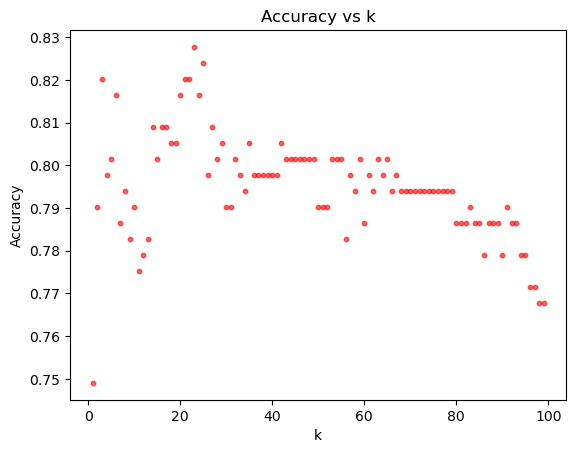

In [122]:
 # Visualize.
plt.scatter(k_grid,accs,c='red',marker='o',s=10,alpha=0.6)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

1.7. KNN hyperparameter optimization:

In [123]:
# Parameter grid.
k_grid = np.arange(1,51,1)
parameters = {'n_neighbors':k_grid}


In [125]:
# Optimize the k.
gridCV = GridSearchCV(KNeighborsClassifier(), parameters, cv=10, n_jobs = -1)  # "n_jobs = -1" means "use all the CPU cores".
gridCV.fit(X_train, Y_train)
best_k = gridCV.best_params_['n_neighbors']
print("Best k : " + str(best_k))


Best k : 37


In [128]:
# Test with the best k.
KNN_best = KNeighborsClassifier(n_neighbors=best_k)
KNN_best.fit(X_train, Y_train)
Y_pred = KNN_best.predict(X_test)
print( "Best Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))


Best Accuracy : 0.798
